# Reinvent4を使いEGFR kinase阻害剤様の構造生成モデルを作成する

転移学習とSamplingを利用してEGFR kinase阻害剤様の構造生成モデルを作成しましょう。

注）reinvent4は以下のようにCLIで利用しますが、本ハンズオンではjupyter上で実行するためsubprocessを利用します。

```bash
$ reinvent -l log.txt config.toml
```

## 転移学習に利用するEGFR kinase阻害剤の構造を確認する

rdkitを利用して構造を描画し確認します。

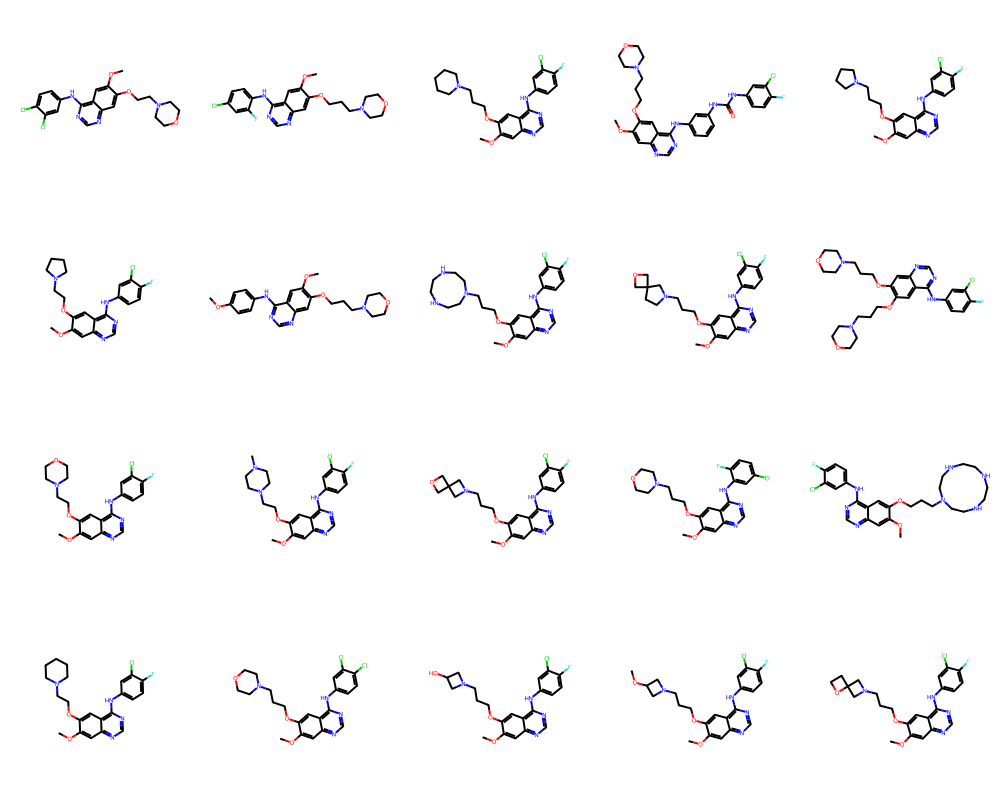

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
df = pd.read_csv('../data/genai/ChEMBL_EGFR.csv')
df.head(2)
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in df.smiles][:20], molsPerRow=5)

## 設定ファイル(toml)を編集する

../data/genai/ 以下にTomlファイルがありますので、各自の環境に応じて編集をしてください。
以下に今回の転移学習で利用するファイル(transfer_learning.toml)を出力しますが、書き換える必要のある変数は

- device: cudaの場合はcuda:0, MacOS(M1,M2,M3)のgpuの場合はmps, gpuを利用しない場合はcpuを指定してください
- input_model_file, smiles_file, output_model_file, validation_smiles_fileは書き換える必要があります
- 今回はnum_epocを300にしていますがCPUのみの場合は学習に時間がかかるかもしれません。その場合は100に変更してください

In [3]:
!cat ../data/genai/transfer_learning.toml

# REINVENT4 TOML input example for transfer learning
#
# Focus a given model towards a set of input SMILES.  This can also be used to
# start from scratch from and an untrained prior.


run_type = "transfer_learning"
device = "cuda:0"  # set torch device e.g. "cpu"
tb_logdir = "tb_TL"  # name of the TensorBoard logging directory
json_out_config = "json_transfer_learning.json"  # write this TOML to JSON


[parameters]

num_epochs = 300  # number of steps to run
save_every_n_epochs = 3  # save checkpoint model file very N steps
batch_size = 50
num_refs = 5  # number of reference molecules randomly chosen for similarity
                # set this to zero for large datasets (>200 molecules)!
sample_batch_size = 100  # number of sampled molecules to compute sample loss
# Uncomment one of the comment blocks below.  Each generator needs a model
# file and possibly a SMILES file with seed structures.

## Reinvent
input_model_file = "/home/iwatobipen/dev/REINVENT4/priors/reinvent.prior"
smiles_

## 転移学習を実施
reinventコマンドは各自の環境に依存しますので設定してください

注）仮想環境のpathを調べたい場合は以下のコマンドを実行してください

```bash
$ % conda info --envs
```

In [4]:
import subprocess

In [5]:
subprocess.call(
    ["/home/iwatobipen/miniforge3/envs/reinvent4/bin/reinvent", "-l", "TL.log", "../data/genai/transfer_learning.toml"]
)

|          |00:00
Epoch 300: |##########|00:38
0it [00:38, ?it/s]


0

## tensroboardでログを確認
tensorboardはReinvent4と同じ環境下にインストールされているので、以下のコマンドを実行するとwebブラウザから転移学習の結果を確認することができます。

In [6]:
!/home/iwatobipen/miniforge3/envs/reinvent4/bin/tensorboard --logdir tb_TL/

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
E1028 15:16:42.135416 133466746259136 _internal.py:96] Error on request:
Traceback (most recent call last):
  File "/home/iwatobipen/miniforge3/envs/reinvent4/lib/python3.10/site-packages/werkzeug/serving.py", line 362, in run_wsgi
    execute(self.server.app)
  File "/home/iwatobipen/miniforge3/envs/reinvent4/lib/python3.10/site-packages/werkzeug/serving.py", line 323, in execute
    application_iter = app(environ, start_response)
  File "/home/iwatobipen/miniforge3/envs/reinvent4/lib/python3.10/site-packages/tensorboard/backend/application.py", line 528, in __call__
  

##　訓練前後のモデルでサンプリング（構造生成）

ここでは、転移学習前後の生成モデルから構造生成を行い、EGFR阻害剤様の構造が出力されているか確認します。
転移学習と同様にtomlファイルを設定する必要があります。

sampling.tomlは転移学習前の生成モデルからのサンプリングで、TL_sampling.tomlは転移学習後の生成モデルからのサンプリング用の設定ファイルです。
編集が必要な箇所はdevice,model_fileです。


In [7]:
!cat ../data/genai/sampling.toml

# REINVENT4 TOML input example for sampling
#


run_type = "sampling"
device = "cuda:0"  # set torch device e.g. "cpu"
json_out_config = "_sampling.json"  # write this TOML to JSON


[parameters]

# Uncomment one of the comment blocks below.  Each generator needs a model
# file and possibly a SMILES file with seed structures.

## Reinvent: de novo sampling
model_file = "/home/iwatobipen/dev/REINVENT4/priors/reinvent.prior"

## LibInvent: find R-groups for the given scaffolds
#model_file = "priors/libinvent.prior"
#smiles_file = "scaffolds.smi"  # 1 scaffold per line with attachment points

## LinkInvent: find a linker/scaffold to link two fragments
#model_file = "priors/linkinvent.prior"
#smiles_file = "warheads.smi"  # 2 warheads per line separated with '|'

## Mol2Mol: find molecules similar to the provided molecules
#model_file = "priors/mol2mol_medium_similarity.prior"
#smiles_file = "mol2mol.smi"  # 1 compound per line
#sample_strategy = "beamsearch"  # multinomial or beamsearch (

In [8]:
#訓練前のモデル
subprocess.call(
    ["/home/iwatobipen/miniforge3/envs/reinvent4/bin/reinvent", "-l", "sampling.log", "../data/genai/sampling.toml"]
)

0

In [9]:
!cat ../data/genai/TL_sampling.toml

# REINVENT4 TOML input example for sampling
#


run_type = "sampling"
device = "cuda:0"  # set torch device e.g. "cpu"
json_out_config = "_TL_sampling.json"  # write this TOML to JSON


[parameters]

# Uncomment one of the comment blocks below.  Each generator needs a model
# file and possibly a SMILES file with seed structures.

## Reinvent: de novo sampling
model_file = "/home/iwatobipen/dev/CBI/cheminfo_tutorial_20241028/notebook/models/TL_reinvent.model"

## LibInvent: find R-groups for the given scaffolds
#model_file = "priors/libinvent.prior"
#smiles_file = "scaffolds.smi"  # 1 scaffold per line with attachment points

## LinkInvent: find a linker/scaffold to link two fragments
#model_file = "priors/linkinvent.prior"
#smiles_file = "warheads.smi"  # 2 warheads per line separated with '|'

## Mol2Mol: find molecules similar to the provided molecules
#model_file = "priors/mol2mol_medium_similarity.prior"
#smiles_file = "mol2mol.smi"  # 1 compound per line
#sample_strategy = "beamse

In [10]:
#訓練後のモデル
subprocess.call(
    ["/home/iwatobipen/miniforge3/envs/reinvent4/bin/reinvent", "-l", "TL_sampling.log", "../data/genai/TL_sampling.toml"]
)

0

## 構造を確認する

転移学習前後で生成モデルの出力する構造を確認します。転移学習後の生成モデルからはキナゾリン骨格が多く生成されていることを確認してください。

In [11]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

In [12]:
df1 = pd.read_csv('sampling.csv')
print(df1.shape)
df1.tail(2)

(154, 2)


,SMILES,NLL
152,COc1cc(-c2cccc(NC(=O)c3ccc4nccnc4c3)c2)cc(OC)c1OC,26.78
153,CCCCC1C2CCCN3CCCC(CN1S(=O)(=O)c1ccccc1)C23,21.12


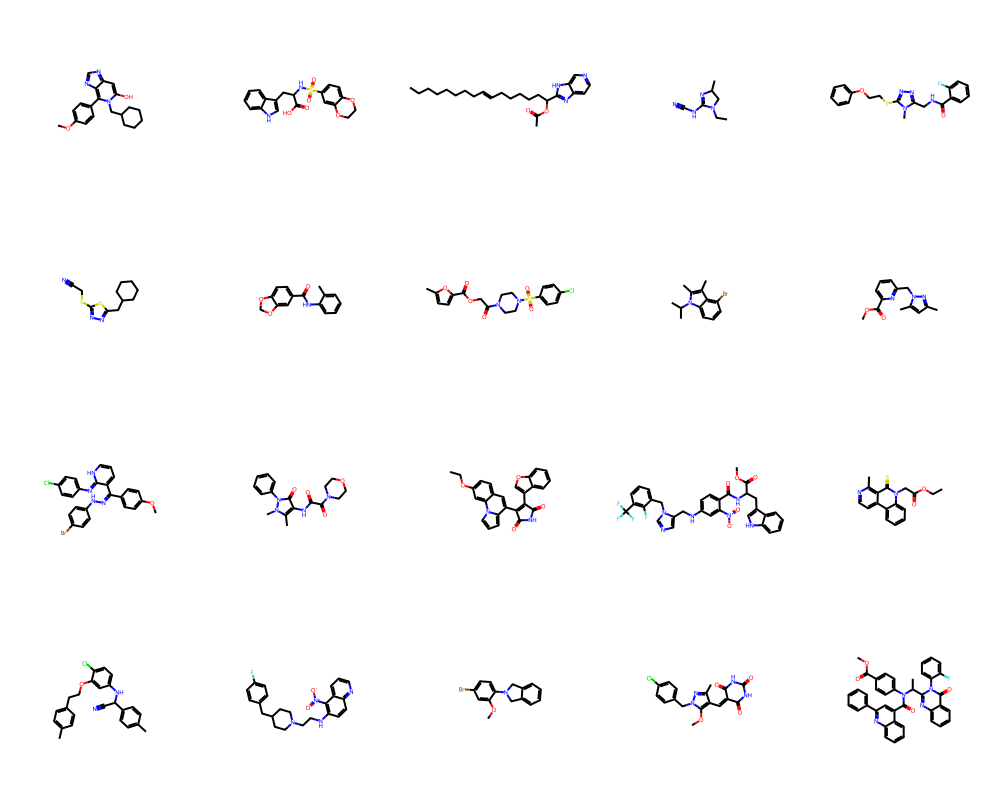

In [13]:
PandasTools.AddMoleculeColumnToFrame(df1, smilesCol='SMILES')
Draw.MolsToGridImage(df1.ROMol[:20], molsPerRow=5)

In [14]:
df2= pd.read_csv('TL_sampling.csv')
print(df2.shape)
df2.tail(2)

(28, 2)


,SMILES,NLL
26,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,3.17
27,COc1cc(C(=O)NCCCn2cccn2)cc(OC)c1OC,20.36


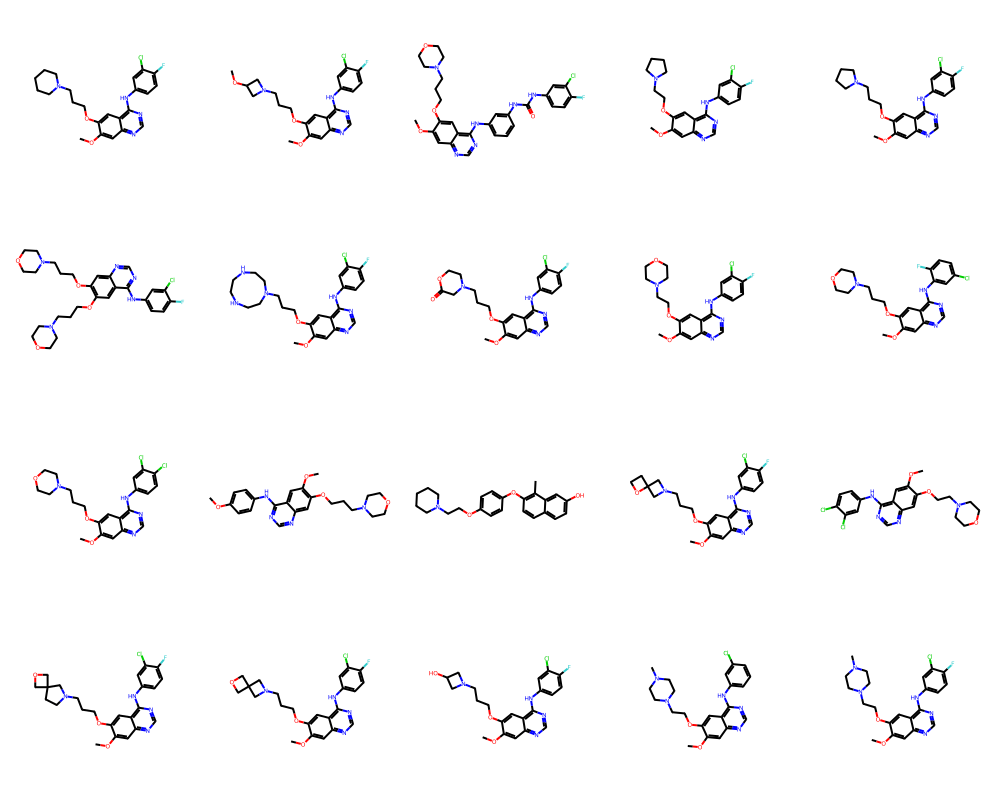

In [15]:
PandasTools.AddMoleculeColumnToFrame(df2, smilesCol='SMILES')
Draw.MolsToGridImage(df2.ROMol[:20], molsPerRow=5)